In [1]:
# Christopher Figueroa
# First Aircraft Health Code

# skfuzzy imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skfuzzy as fuzz

# control and rule import
from skfuzzy import control as ctrl
# adaptive neuro fuzzy
import sklearn.datasets

# import for random number generator
import random

# imports numpy for dot product and sigmoid
import numpy as np
import torch
# torch for loss function
import torch.nn.functional as F

In [2]:
# function has domain of [-1, 1] and 50 rows and 1 column
x = torch.unsqueeze(torch.linspace(-1, 1, 50), dim=1)

# represents a flat function of the value zero
infunc =  x*0

In [3]:
# initializes the RegressorNet class
class RegressorNet(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(RegressorNet, self).__init__()
        # the output of one layer is equal to the output of the layer below
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        
        # new hidden layers
        self.newhidden = torch.nn.Linear(n_hidden, n_hidden)
        self.newhidden2 = torch.nn.Linear(n_hidden, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    # xin is input, xout is output
    def forward(self, xin):
        xout = F.relu(self.hidden(xin))    # the output of hidden layer
        
        # the output of new hidden layers
        xout = F.relu(self.newhidden(xout))
        xout = F.relu(self.newhidden2(xout))
        xout = self.predict(xout)     # the output of net
        return xout

In [4]:
# initializes the net variable
net = RegressorNet(n_feature=1, n_hidden=6, n_output=1)
    # tested n_hidden values 1-20: '16' yielded best results

    # tested lr values 0.01 - 0.2: '0.07' yielded best results
# lr is the learning rate (Alpha)
learner = torch.optim.SGD(net.parameters(), lr=0.1)
# declares the Mean square error loss function
loss_func = torch.nn.MSELoss()

# initializes a list to store the accuracy
averages = []

In [5]:
# defines the rules with their crisp universes
vibration = ctrl.Antecedent(np.arange(0, 1.21, 0.01), 'vibration')
temperature = ctrl.Antecedent(np.arange(0, 101, 1), 'temperature')
pressure = ctrl.Antecedent(np.arange(0, 5.1, 0.1), 'pressure')
electric = ctrl.Antecedent(np.arange(0, 141, 1), 'electric')
rotation = ctrl.Antecedent(np.arange(0, 5010, 10), 'rotation')

# defines output
repair = ctrl.Consequent(np.arange(0, 101, 1), 'repair')

In [6]:
# the variables below are based off the averages of aircraft components

# defines the input variables
# vibration is measured in a scale of 0-1.2 inches per second (IPS)
vibration['mild'] = fuzz.trapmf(vibration.universe, [0, 0, 0.2, 0.3])
vibration['moderate'] = fuzz.trapmf(vibration.universe, [0, 0.2, 0.6, 0.9])
vibration['severe'] = fuzz.trapmf(vibration.universe, [0.5, 0.6, 1.2, 1.2])

# temperature of the engines is measured in Fahrenheight
temperature['cold'] = fuzz.trapmf(temperature.universe, [0, 0, 20, 25])
temperature['moderate'] = fuzz.trapmf(temperature.universe, [10, 20, 60, 80])
temperature['hot'] = fuzz.trapmf(temperature.universe, [40, 60, 100, 100])

# the differential of the cabin and the outside pressure, surface PSI 14.7
pressure['minimal'] = fuzz.trapmf(pressure.universe, [0, 0, 1.6, 2.4])
pressure['medium'] = fuzz.trapmf(pressure.universe, [0, 1.6, 4, 4.5])
pressure['significant'] = fuzz.trapmf(pressure.universe, [3.6, 4, 5, 5])

# the voltage of the electric systems in the aircraft
electric['weak'] = fuzz.trapmf(electric.universe, [0, 0, 100, 110])
electric['medium'] = fuzz.trapmf(electric.universe, [70, 100, 130, 135])
electric['excessive'] = fuzz.trapmf(electric.universe, [120, 130, 140, 140])

# measures the rotation of the engine fan in RPM
rotation['slow'] = fuzz.trapmf(rotation.universe, [0, 0, 2500, 3000])
rotation['nominal'] = fuzz.trapmf(rotation.universe, [1000, 2500, 4000, 4500])
rotation['fast'] = fuzz.trapmf(rotation.universe, [3500, 4000, 5000, 5000])

# defines the output variables
repair['no'] = fuzz.trapmf(repair.universe, [0, 0, 45, 55])
repair['yes'] = fuzz.trapmf(repair.universe, [45, 55, 100, 100])

In [7]:
# the upper and lower extremes
rule1 = ctrl.Rule(vibration['severe'] | temperature['hot'] |
                  temperature['cold'] | electric['weak'] |
                  pressure['significant'] | electric['excessive'] |
                  rotation ['slow'] |
                  rotation['fast'], repair['yes'])
# the no maintenence values
rule2 = ctrl.Rule(vibration['moderate'] & temperature['moderate'] &
                  pressure['medium'] & electric['medium'] &
                  rotation['nominal'], repair['no'])

# sets up control system
liquidity_ctrl = ctrl.ControlSystem([rule1, rule2])
liquidcalc = ctrl.ControlSystemSimulation(liquidity_ctrl)

In [8]:
# ideal dedault crisp values
crisp_vib = 0.4
crisp_temp = 40
crisp_pres = 2.8
crisp_elec = 120
crisp_rot = 3250

# ideal default crisp values
liquidcalc.input['vibration'] = crisp_vib
liquidcalc.input['temperature'] = crisp_temp
liquidcalc.input['pressure'] = crisp_pres
liquidcalc.input['electric'] = crisp_elec
liquidcalc.input['rotation'] = crisp_rot

In [9]:
# initializes Mean Absolute Percentage Error function
def get_mape(vib, temp, pres, elec, rot):
    diff_vib = (abs(0.4-vib) / 0.4) * 100
    diff_temp = (abs(40-temp) / 40) * 100
    diff_pres = (abs(2.8-pres) / 2.8) * 100
    diff_elec = (abs(120-elec) / 120) * 100
    diff_rot = (abs(3250-rot) / 3250) * 100
    mape = (diff_vib+diff_temp+diff_pres+diff_elec+diff_rot) / 5
    return mape

# calls function
testmape = get_mape(crisp_vib, crisp_temp, crisp_pres, crisp_elec, crisp_rot)
print(testmape)

0.0


Vibration:  0.4  IPS
Temperature:  40 F
Pressure Difference:  2.8 PSI
Electric Flow:  120 V
Rotation:  3250 RPM
25.08333333333333


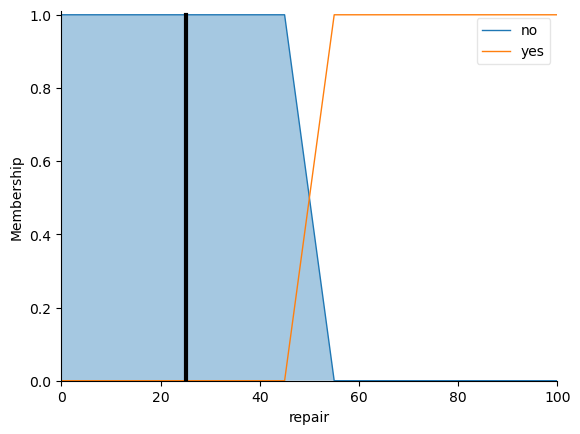

In [11]:
# prints crisp values
print("Vibration: ", crisp_vib, " IPS")
print("Temperature: ", crisp_temp, "F")
print("Pressure Difference: ", crisp_pres, "PSI")
print("Electric Flow: ", crisp_elec, "V")
print("Rotation: ", crisp_rot, "RPM")

# computes and shows the fuzzy and crisp results
liquidcalc.compute()
print(liquidcalc.output['repair'])
repair.view(sim=liquidcalc)

99.99639
99.99982
99.99987
99.9999
99.99992
99.99993
99.99994
99.99995
99.99996
99.99996


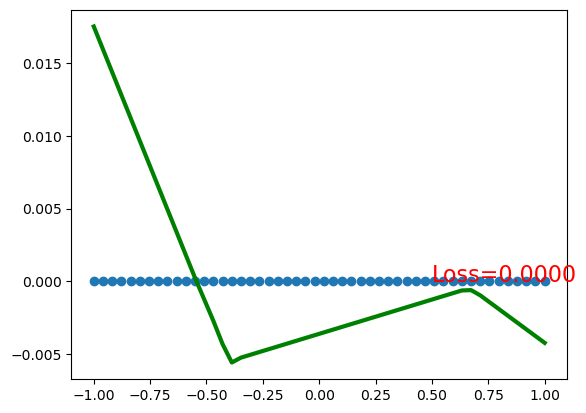

Function: x*0 + 25
Total Average:  99.99956 %


In [12]:
# the 500 is the number of times the forward and backward pass are done
for t in range(1000):
    # prediction variable stores net variable
    # beginning of forward pass
    prediction = net(x)
    # Loss from input
    loss = loss_func(prediction, infunc)
    
    # start of backward pass
    learner.zero_grad()   # resets values for next iteration
    loss.backward()
    # the loss.backward is the computation of the Partial Derivative
    learner.step()
    # performs the change inside the neural network

    # prints out the loss for every 10 t units
    if t % 100 == 0:
        accuracy = 100 - loss.data.numpy()
        averages.append(accuracy)
        # rounds accuracy up to 5 decimal places
        print(round(accuracy,5))
        
# makes a scatter plot
plt.cla()
plt.scatter(x.data.numpy(), infunc.data.numpy())
plt.plot(x.data.numpy(), prediction.data.numpy(), 'g', lw=3)    
plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 16, 'color':  'red'})
plt.show()
        
# calculates total accuracy average
average = sum(averages) / len(averages)
print("Function: x*0 + 25")
print("Total Average: ", round(average,5), "%")

Vibration:  0.04  IPS
Temperature:  92 F
Pressure Difference:  2.9 PSI
Electric Flow:  2 V
Rotation:  2685 RPM
Loss before repair:  67.85787545787545
Vibration:  0.45  IPS
Temperature:  46 F
Pressure Difference:  3.0 PSI
Electric Flow:  124 V
Rotation:  3403 RPM
Loss after repair:  8.536776556776557
----------------------------
Vibration:  0.76  IPS
Pressure Difference:  0.3 PSI
Electric Flow:  5 V
Rotation:  2292 RPM
Loss before repair:  63.91919413919413
Vibration:  0.3  IPS
Pressure Difference:  3.0 PSI
Electric Flow:  127 V
Rotation:  3487 RPM
Loss after repair:  12.053699633699637
----------------------------
Temperature:  67 F
Rotation:  2466 RPM
Loss before repair:  25.91985347985348
Temperature:  42 F
Rotation:  2770 RPM
Loss after repair:  11.54908424908425
----------------------------
Pressure Difference:  2.2 PSI
Rotation:  1256 RPM
Loss before repair:  23.72315018315018
Pressure Difference:  2.8 PSI
Rotation:  2964 RPM
Loss after repair:  8.926666666666668
-----------------

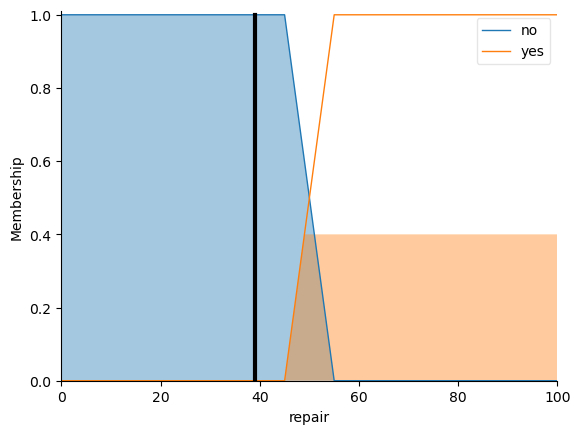

In [17]:
# generates time for mechanical faults
interval = random.randrange(50,150)
faults = interval
# creates a list of faulty variables
faulty = []

# 1000 hours of flight
for hours in range(1000):
    
    # when an interval is reached
    if hours == faults:
        interval = random.randrange(50,150)
        
        # selects which crisp variables are due for maintenence
        amount = random.randrange(1,6)
        selected = []

        # appends to indexes of selected values
        while amount>0:
            value = random.randrange(1,6)
            # makes sure there are no duplicates
            if value not in selected:
                amount = amount-1
                selected.append(value)
            else:
                value = random.randrange(1,6)
        
        # applies the new values to the selected variables
        if 1 in selected:
            crisp_vib = float(random.randrange(1,120))/100
            liquidcalc.input['vibration'] = crisp_vib
            print("Vibration: ", crisp_vib, " IPS")
            
        if 2 in selected:
            crisp_temp = random.randrange(1,100)
            liquidcalc.input['temperature'] = crisp_temp
            print("Temperature: ", crisp_temp, "F")
            
        if 3 in selected:
            crisp_pres = float(random.randrange(1,50))/10
            liquidcalc.input['pressure'] = crisp_pres
            print("Pressure Difference: ", crisp_pres, "PSI")
            
        if 4 in selected:
            crisp_elec = random.randrange(1,140)
            liquidcalc.input['electric'] = crisp_elec
            print("Electric Flow: ", crisp_elec, "V")
            
        if 5 in selected:
            crisp_rot = random.randrange(1,5000)
            liquidcalc.input['rotation'] = crisp_rot
            print("Rotation: ", crisp_rot, "RPM")
        
        mapes = get_mape(crisp_vib, crisp_temp, crisp_pres, crisp_elec, crisp_rot)
        print("Loss before repair: ", mapes)
        
        # appends items that need repairs into list
        for i in selected:
            if i not in faulty:
                faulty.append(i)
        
        # selects the next fault interval
        faults = faults + interval
    
        # determines what values to input for maintenence
        if 1 in faulty:
            crisp_vib = float(random.randrange(30,50))/100
            liquidcalc.input['vibration'] = crisp_vib
            faulty.remove(1)
            print("Vibration: ", crisp_vib, " IPS")
            
        if 2 in faulty:
            crisp_temp = random.randrange(30,50)
            liquidcalc.input['temperature'] = crisp_temp
            faulty.remove(2)
            print("Temperature: ", crisp_temp, "F")
            
        if 3 in faulty:
            crisp_pres = float(random.randrange(23,33))/10
            liquidcalc.input['pressure'] = crisp_pres
            faulty.remove(3)
            print("Pressure Difference: ", crisp_pres, "PSI")
            
        if 4 in faulty:
            crisp_elec = random.randrange(110,130)
            liquidcalc.input['electric'] = crisp_elec
            faulty.remove(4)
            print("Electric Flow: ", crisp_elec, "V")
            
        if 5 in faulty:
            crisp_rot = random.randrange(2750,3750)
            liquidcalc.input['rotation'] = crisp_rot
            faulty.remove(5)
            print("Rotation: ", crisp_rot, "RPM")
        
        mapes = get_mape(crisp_vib, crisp_temp, crisp_pres, crisp_elec, crisp_rot)
        liquidcalc.compute()
        print("Loss after repair: ", mapes)
        print("----------------------------")

# computes and shows the fuzzy and crisp results
liquidcalc.compute()
print(liquidcalc.output['repair'])
repair.view(sim=liquidcalc)